In [1]:
'''
This script runs over each data file and finds the peaks from each file.
An image is output containing the energy and timing information from each data file
along with one final image containing the combined results from all files.
'''
%load_ext autoreload
%autoreload 2

In [2]:
#importing the file reading class, this also includes many other libraries with it. Open that file to see what is required
import noptrexAnalysis as na #includes the function to do the peak finding
import os #used for file operations
from pylab import rcParams #used to change how large the plots are
from scipy.optimize import curve_fit #the fitting function
from scipy.special import wofz #used to define the voigt function
from scipy.signal import find_peaks #helps find peaks in waveform files 
#these are all imported for multiprocessing work
from multiprocessing import Lock, Process, Queue, current_process 
import multiprocessing as mp
import time #returns time information
import queue # imported for using queue.Empty exception
import pickle

In [3]:
#here we define a few values that will be used heavily throughout the next chunk of processing
overwrite = False #this tells the code to overwrite previous result files or to skip them
makeNewPng = False #if you are overwriting and want to make a new image

numDataPoints = 500000
#set up the binning information
numTimeBinsSaved = int(numDataPoints) #these two are when the files are saved to the histogram files for later analysis
enerBinsSaved = na.np.arange(4000)
numberOfCores = -1 #how many cpu cores to use, -1 means use everything

#this is approximately when the gamma flash happens in each file in units of timebins (10ns)
flashTime = 56500

#tell the script what file or directory to analyze
dataSetName = 'Small Chunk of Cold Runs' #output image files will have this in the name to identify the source
dataToAnalyze = '/home/david/datafiles/noptrex/coldRuns/'

In [4]:
#This block contains a bunch of frequently used functions that should be defined somewhere

#This function finds all of the binary files at the path given to it
#in the case that just a file is given to it, it makes a list with that file being the one entry (for compatibility with later functions)
def getFileNames(fileDir):
    dataFileNames = []
    if os.path.isdir(fileDir):  #if the given path is a directory, find all data files in that directory and analyze them
        tempFileNames = [f for f in os.listdir(fileDir) if os.path.isfile(os.path.join(fileDir, f))] #grab all files that are actually files, not directories
        tempFileNames = [fileDir + fileName for fileName in tempFileNames] #now add the path to the files onto each one
        #only grab the ones that are actually data files and have a .bin extension, otherwise ignore them
        for file in tempFileNames:
                name, extension = os.path.splitext(file)
                if extension == '.bin':
                    dataFileNames.append(file)
    elif os.path.isfile(fileDir): #if it is a file, assume they knew what they were doing and provided a real file  
        dataFileNames = [fileDir]
    return dataFileNames

#define some functions that are used later on
def outputResults(inputTimeHist, inputEnerHist, file):
    timeHistBins = inputTimeHist[1]
    timeHist = inputTimeHist[0]
    enerHistBins = inputEnerHist[1]
    enerHist = inputEnerHist[0]
    #determine the output file name
    inputName, inputExtension = os.path.splitext(file)
    outputFilename = inputName
    print('\t saving as '+outputFilename +'.npz')
    na.np.savez(outputFilename, timeHistBins=timeHistBins, timeHist=timeHist, enerHistBins=enerHistBins, enerHist=enerHist) #save the histograms
    return

def getRunNumber(filename):
    withoutPath = os.path.basename(filename)
    inputName, inputExtension = os.path.splitext(withoutPath)
    return inputName

def grabResultFiles(fileDir):
    #check if this is a file or a directory
    if os.path.isdir(fileDir): #if a directory, make a list of all .csv files and return that
        files = []
        for file in os.listdir(fileDir):
            if file.endswith(".npz"):
                files.append(os.path.join(fileDir, file))
        return files
    elif os.path.isfile(fileDir): #return just the filename as a list if this is the case
        return [fileDir]
    else:
        print("file given doesn't work")
        return
    return
    
def makePlot(filenames, numPoints, timeHist, enerHist, manualName = False):
    rcParams['figure.figsize'] = 15, 5 #change how large the plot will be
    f, (ax1, ax2) = na.plt.subplots(1, 2) #create the 2 plots side by side
    #plot the time of flight 
    if manualName == True:
        ax1.plot(timeHist[1][:-1], timeHist[0])
    else:
        ax1.plot(timeHist[1][:-1], timeHist[0])
    ax1.set_title('Time of Flight')
    ax1.set_xlim(0.5, 4.0)
    #ax1.set_ylim(0,10000)
    ax1.set_xlabel('Time (ms)')
    ax1.set_ylabel('Counts (logscale)')
    ax1.set_yscale('log')
    #plot the energy
    ax2.plot(enerHist[1][:-1], enerHist[0])
    ax2.set_title('Energy Spectrum')
    ax2.set_xlim(0,1000)
    ax2.set_xlabel('Energy (ADC)')
    ax2.set_ylabel('Counts')
    if manualName == True:
        f.suptitle(filenames + ' : '+str(numPoints) + ' pulses identified')
        outputname = filenames+'.png'
    else:
        #figure out the output name and the title of the plot
        outputname = None
        if(len(filenames) == 1):
            f.suptitle(getRunNumber(filenames[0]) + '  : '+str(numPoints) + ' pulses identified')
            outputname = os.path.dirname(filenames[0]) +'/'+ getRunNumber(filenames[0])+'res.png'        
        else:
            f.suptitle(getRunNumber(filenames[0]) + ' - ' + getRunNumber(filenames[-1]) + ': '+str(numPoints) + ' pulses identified')
            outputname = os.path.dirname(filenames[0])+'/'+getRunNumber(filenames[0])+'-'+getRunNumber(filenames[-1])+'res.png'
    print('\t'+str(outputname))
    f.savefig(outputname)
    f.clf()

#now define the analysis function
#this function will check the file name given to it and see if it needs to do the analysis on it
def analyzeOneFile(file, numTimeBins, enerBins, overwrite = False, makeNewPng = False):
    inputName, inputExtension = os.path.splitext(file)
    outputFilename = inputName+'.npz'
    if os.path.isfile(outputFilename) and overwrite == False and makeNewPng == False: 
        #if the results exist and we don't want to modify them, do nothing
        print('\t results already exist, moving on')
    elif os.path.isfile(outputFilename) and overwrite == False and makeNewPng == True:
        #if the results exist and we do want to update the plot, maybe we changed some settings or something
        print('\t loading existing results to update plots')
        dataFile = na.np.loadtxt(outputFilename, delimiter = ', ')
        totPeakX = dataFile[0][:]
        totPeakY = dataFile[1][:]
        print('\t making new plot')
        timeHist = na.np.histogram(totPeakX, bins = numTimeBins)
        enerHist = na.np.histogram(totPeakY, bins = enerBins)
        #make the image files
        makePlot([file], len(totPeakX), timeHist, enerHist)
    else: #if the file doesn't exist, or we are going to overwrite it, do the normal process
        #load the file into RAM
        print('\t making new results file')
        dataFile = na.dataFile(file)
        print('\t loaded '+str(file))
        #find the peak information for that file, x and y coordinates (time and energy)
        peakX, peakY = na.findPeaksInWaveforms(dataFile)
        print('\t found peaks ' + str(file))
        #now bin this information, remember that each peak list is per waveform, and then the peaks in each waveform, we want to bundle all of that together
        totPeakX = [item for sublist in peakX for item in sublist] #unpacks the list of lists into one list
        totPeakY = [item for sublist in peakY for item in sublist] #same again but for the y coordinate information

        outputResults(totPeakX, totPeakY, file)
        dataFile = 0 #free out the old data file, or at least signal it should be freed out

        #bin the data
        timeHist = na.np.histogram(totPeakX, bins = numTimeBins)
        enerHist = na.np.histogram(totPeakY, bins = enerBins)
        #make the image files
        makePlot([file], len(totPeakX), timeHist, enerHist)
    return

#define some functions that will use parallel processing to accelerate the data analysis
#be careful when calling these, they can rapidly take up all available RAM as each CPU will handle a different data file
def do_job(tasks_to_accomplish, tasks_that_are_done, numTimeBins, enerBins, overwrite, makeNewPng):
    while True:
        try:
            #tries to get a task
            task = tasks_to_accomplish.get_nowait()
        except queue.Empty:
            #if there are no tasks to get, then do this
            print('nothing left in queue: '+current_process().name)
            break
        else:
            #if it found a task, then do the work on that task
            print(task, current_process().name)
            analyzeOneFile(task, numTimeBins, enerBins, overwrite = overwrite, makeNewPng = makeNewPng)
            tasks_that_are_done.put(task + ' is done by ' + current_process().name)
            time.sleep(.5)
    return True

def doBulkAnalysisOnMultipleCores(dataDir, numberOfCores, numTimeBins, enerBins, overwrite, makeNewPng):
    #grab all the data file names
    dataFileNames = getFileNames(dataDir)
    dataFileNames.sort() #sort them in numerical order, just kinda nice to do
    number_of_task = len(dataFileNames) #chose this to keep the RAM usage within reason
    number_of_processes = numberOfCores
    tasks_to_accomplish = Queue()
    tasks_that_are_done = Queue()
    processes = []

    for i in range(number_of_task):
        tasks_to_accomplish.put(dataFileNames[i])

    # creating processes
    for w in range(number_of_processes):
        p = Process(target=do_job, args=(tasks_to_accomplish, tasks_that_are_done, numTimeBins, enerBins, overwrite, makeNewPng))
        processes.append(p)
        p.start()

    # completing process
    for p in processes:
        p.join()

    # print the output
    while not tasks_that_are_done.empty():
        print(tasks_that_are_done.get())
    return

#this is the peak find function for each waveform
def findOneWavesPeaks(wave):
    height = None 
    threshold = None 
    distance = 30
    prominence = 50
    width = None
    wlen = None
    rel_height = 0.5
    plateau_size = None
    tempWave = -wave[:]
    baseline = na.np.mean(tempWave[0:1000])
    tempWave = tempWave[:] - baseline
    #look for peaks at least 10 bins apart from each other
    #other parameters are their default values
    peaks, properties = find_peaks(tempWave, height=height, threshold=threshold, distance=distance, prominence=prominence, width=width, wlen=wlen, rel_height=rel_height, plateau_size=plateau_size)
    amps = tempWave[peaks]
    return [peaks*10**(-5), amps]

def alternativeParallelization(dirName, numberOfCores, numTimeBins, enerBins, overwrite, makeNewPng):
    #this is an alternative method using Pool instead
    #it parallezies the workload on a per file basis, instead of doing multiple files at once
    #saves on RAM and could potentially be more efficient with the files as well
    dataFileNames = getFileNames(dirName)
    dataFileNames.sort() #sort them in numerical order, just kinda nice to do
    #now use the pool methodology to distribute the workload
    if(numberOfCores == -1):
        numberOfCores = mp.cpu_count()
    pool = mp.Pool(mp.cpu_count())
    #now iterate over the files
    for file in dataFileNames:
        inputName, inputExtension = os.path.splitext(file)
        outputFilename = inputName+'.npz'
        if os.path.isfile(outputFilename) and overwrite == False and makeNewPng == False: 
            pass #do nothing
        elif os.path.isfile(outputFilename) and overwrite == False and makeNewPng == True:
            #if the results exist and we do want to update the plot, maybe we changed some settings or something
            print('\t loading existing results to update plots')
            dataFile = na.np.load(outputFilename)
            totPeakX = dataFile[0][:]
            totPeakY = dataFile[1][:]
            print('\t making new plot')
            timeHist = na.np.histogram(totPeakX, bins = numTimeBins)
            enerHist = na.np.histogram(totPeakY, bins = enerBins)
            #make the image files
            makePlot([file], len(totPeakX), timeHist, enerHist)
        else: #if the file doesn't exist, or we are going to overwrite it, do the normal process
            #load the file into RAM
            print('\t making new results file')
            dataFile = na.dataFile(file)
            print('\t loaded '+str(file))

            results = pool.map(findOneWavesPeaks, [wave for wave in dataFile.waves()])
            print('\t found peaks ' + str(file))
            totPeakX = []
            totPeakY = []
            for res in results:
                totPeakX.extend(res[0])
                totPeakY.extend(res[1])
                
            #bin the data
            timeHist = na.np.histogram(totPeakX, bins = numTimeBins)
            enerHist = na.np.histogram(totPeakY, bins = enerBins)
            outputResults(timeHist, enerHist, file)
            
            dataFile = 0 #free out the old data file, or at least signal it should be freed out            
            #make the image files
            makePlot([file], len(totPeakX), timeHist, enerHist)
    return

#once the analysis is done, we need to load in the result files from that work
def grabTotalResults(fileDir):
    tempFileNames = [f for f in os.listdir(fileDir) if os.path.isfile(os.path.join(fileDir, f))] #grab all files that are actually files, not directories
    tempFileNames = [fileDir + fileName for fileName in tempFileNames] #now add the path to the files onto each one
    resultFileNames = []
    #now grab only the csv files that signify results
    for file in tempFileNames:
            name, extension = os.path.splitext(file)
            if extension == '.npz':
                resultFileNames.append(file)
    resultFileNames.sort()
    num = 0
    #set up the bins for the overall result histogram
    #expects a number for time bins, an array of bins for energy bins
    #list containing total results
    results = []
    num = []
    
    for file in resultFileNames:
        #load the file
        #print('starting '+file +'. '+str(resultFileNames.index(file))+' : '+str(len(resultFileNames)))
        dataFile = na.np.load(file)
        #na.np.savez(outputFilename, timeHistBins=timeHistBins, timeHist=timeHist, enerHistBins=enerHistBins, enerHist=enerHist) #save the histograms
        #print('\t loaded '+file)
        #get histograms from file
        tempTimeHist = [dataFile['timeHist'][:],dataFile['timeHistBins'][:]]
        tempEnerHist = [dataFile['enerHist'][:], dataFile['enerHistBins'][:]]
        results.append([tempTimeHist, tempEnerHist])
        num+=na.np.sum(tempTimeHist[0]) #add the total number of binned events from the file
    return results, num

def makeOverallHistogram(results):
    #grab the first bins for both energy and timing
    timeHistBins = results[0][0][1][:]
    enerHistBins = results[0][1][1][:]
    
    timeHist = na.np.zeros(len(results[0][0][0]))
    enerHist = na.np.zeros(len(results[0][1][0]))
    
    for res in results:
        timeHist = na.np.add(timeHist, res[0][0])
        enerHist = na.np.add(enerHist, res[1][0])
    
    return [timeHist, timeHistBins], [enerHist, enerHistBins]


#this function analyzes the gamma flash and determines when it was
def findFlashTime(results):
    #pass this the full results array
    #we only care about the t0 part though
    initFlashTimes = []
    for res in results:
        timeHist = res[0][0][:]
        maxVal = na.np.max(timeHist)
        tempHist = timeHist[:] - maxVal/2
        zero_crossings = na.np.where(na.np.diff(na.np.sign(tempHist)))[0]
        #return the first one, should be where the crosspoint is
        initFlashTimes.append(zero_crossings[0])
    return initFlashTimes

def convertTOFtoEnergy(initHist, flashTime):
    initialTime = initHist[1][flashTime] #this is the t0 value in ms
    #each bin is in ms
    outputBins = initHist[1][flashTime:]-initialTime #arranging the output bins based on how long they are after the initial time
    #these are in units of ms currently
    outputBins = outputBins[:] * 10**(-3) #converts to seconds
    conversionFactor = 1/2 * (939.656*10**6) / ((2.998*10**8)**2) * (24**2) #convert from s to eV (uses mass of neutron, speed of light, length of tube in m)
    #convert from TOF to keV
    for i in range(len(outputBins)):
        outputBins[i] = conversionFactor / (outputBins[i]**2.0)
    return [initHist[0][flashTime:], outputBins]      

In [5]:
#now actually do the analysis
if __name__ == '__main__':
    alternativeParallelization(dataToAnalyze, numberOfCores, numTimeBinsSaved, enerBinsSaved, overwrite, makeNewPng)

In [6]:
#Now make the overall combined result file
#first load in the results
results, nums = grabTotalResults(dataToAnalyze) 
#make the overall histogram
timeHist, enerHist = makeOverallHistogram(results)
#now make the plots
makePlot(dataSetName+'_bulk', nums, timeHist, enerHist, manualName = True)

	Small Chunk of Cold Runs_bulk.png


<Figure size 1080x360 with 0 Axes>

In [7]:
#now analyze the gamma flash and it's consitency
flashTimes = findFlashTime(results)

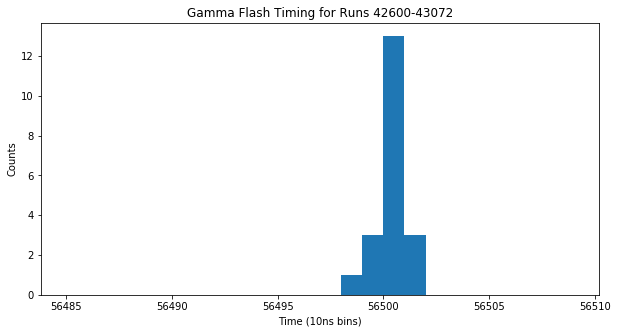

In [8]:
#remove the random extremely low value

realFlashTimes = flashTimes[:]
realFlashTimes.remove(na.np.min(realFlashTimes))
#now histogram it
rcParams['figure.figsize'] = 10, 5
na.plt.hist(realFlashTimes, bins = na.np.arange(56485, 56510))
na.plt.title('Gamma Flash Timing for Runs 42600-43072')
na.plt.xlabel('Time (10ns bins)')
na.plt.ylabel('Counts')
na.plt.savefig('Gamma_Flash_Timing.png')
na.plt.show()

In [9]:
#convert from TOF to keV in the histogram
eVHist = convertTOFtoEnergy(timeHist, flashTime)

/home/david/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:315: RuntimeWarning: divide by zero encountered in double_scalars


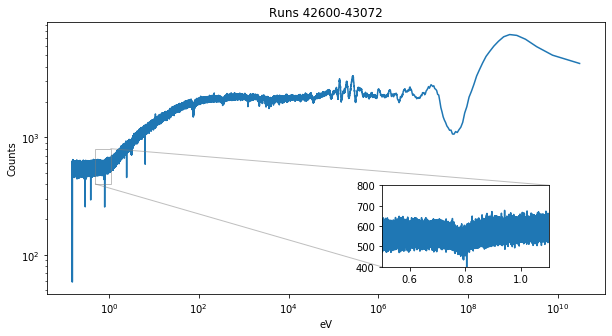

In [10]:
fig, ax = na.plt.subplots(figsize=[10,5])
ax.plot(eVHist[1][:-1], eVHist[0])
ax.set_xlabel('eV')
ax.set_ylabel('Counts')
ax.set_title('Runs 42600-43072')
ax.set_xscale('log')
ax.set_yscale('log')
#na.plt.xlim(0.1,10)
#na.plt.ylim(5000,50000)


# inset axes....
axins = ax.inset_axes([0.6, 0.1, 0.3, 0.3])
axins.plot(eVHist[1][:-1], eVHist[0])
# sub region of the original image
x1, x2, y1, y2 = 0.5, 1.1, 400, 800
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
#axins.set_xticklabels('')
#axins.set_yticklabels('')
ax.indicate_inset_zoom(axins)

fig.savefig('Run42600-43072eVHistogram.png')
na.plt.show()

In [11]:
#now go through and fit the dips in these functions
#define the different fit functions first
def gaussian(x, mu, sig):
    return na.np.exp(-na.np.power(x - mu, 2.) / (2 * na.np.power(sig, 2.)))
    
#define the voigt function stuff
def G(x, alpha):
    #Return Gaussian line shape at x with HWHM alpha
    return na.np.sqrt(na.np.log(2) / na.np.pi) / alpha * na.np.exp(-(x[:] / alpha)**2 * na.np.log(2))

def L(x, gamma):
    # Return Lorentzian line shape at x with HWHM gamma 
    return gamma / na.np.pi / (x[:]**2 + gamma**2)

def V(x, mean, alpha, gamma):
    # Return the Voigt line shape at x with Lorentzian component HWHM gamma and Gaussian component HWHM alpha.
    sigma = alpha / na.np.sqrt(2 * na.np.log(2))
    return na.np.real(wofz((x[:] - mean + 1j*gamma)/sigma/na.np.sqrt(2))) / sigma /na.np.sqrt(2*na.np.pi)


def fitFunc(x, const, linear, quadratic, cubic, amp, mean, alpha, gamma):
    return const + x * linear + quadratic * x**2 + cubic * x**3 + amp * V(x, mean, alpha, gamma)

#now get the initial guesses for the fitting function
def getGuesses(xdata, ydata):
    #use the pseudoinverse method to fit the first chunk of data, kinda cheaty but whatevs
    dataPoints = 400
    basisFuncs = []
    constFunc = na.np.ones(len(ydata))
    linearFunc = na.np.arange(len(ydata))
    quadraticFunc = na.np.arange(len(ydata))[:]**2.0
    cubicFunc = na.np.arange(len(ydata))[:]**3.0
    basisFuncs.append(constFunc[:dataPoints])
    basisFuncs.append(linearFunc[:dataPoints])
    basisFuncs.append(quadraticFunc[:dataPoints])
    basisFuncs.append(cubicFunc[:dataPoints])
    basisFuncs = na.np.asmatrix(basisFuncs)
    inverse = na.np.linalg.pinv(basisFuncs)
    fitParams = na.np.matmul(na.np.transpose(inverse), ydata[:dataPoints])
    constGuess = fitParams[0,0]
    linearGuess = fitParams[0,1]
    quadraticGuess = fitParams[0,2]
    cubicGuess = fitParams[0,3]
    mean = 0.7 #in eV
    #amplitude
    minVal = na.np.min(ydata)
    minLoc = na.np.argmin(ydata)
    excludingGaussianFunc = constGuess * constFunc[minLoc] + linearGuess * linearFunc[minLoc] + quadraticGuess * quadraticFunc[minLoc] + cubicGuess * cubicFunc[minLoc]
    amplitude = minVal - excludingGaussianFunc
    alpha = 0.05
    gamma = 0.01
    return [constGuess, linearGuess, quadraticGuess, cubicGuess, amplitude, mean, alpha, gamma]

#actually do the fitting
def doFitting(xdata, ydata):
    guesses = getGuesses(xdata, ydata)
    popt, pcov = curve_fit(fitFunc, xdata, ydata, p0 = guesses, maxfev = 10000)
    return popt, pcov

def determineChiSquare(fittedFunc, originalValues, numberFitParams):
    chiSquared = 0
    for i in range(len(fittedFunc)):
        tempChi = ((fittedFunc[i] - originalValues[i])**2.0)/originalValues[i]
        chiSquared += tempChi
    chiSquared = chiSquared / ((len(fittedFunc) - numberFitParams))
    return chiSquared
    
    
#actually fit the data set
def fitDataSet(hist, fitWindowLeft, fitWindowRight, dataName, ylim, makePlot):
    xdata = hist[1][fitWindowLeft:fitWindowRight]
    ydata = hist[0][fitWindowLeft:fitWindowRight]
    fitRes, pcov = doFitting(xdata, ydata)
    perr = na.np.sqrt(na.np.diag(pcov))
    fittedFunc = fitFunc(xdata, *fitRes)
    chiSquared = determineChiSquare(fittedFunc, ydata, len(fitRes))
    #now determine the chi square
    #plot the results
    if makePlot:
        fig, ax = na.plt.subplots()
        ax.plot(xdata, ydata, label='original data')
        #na.plt.plot(xdata, fitFunc(xdata, *getGuesses(xdata, ydata)), label='initial fit guesses')
        ax.plot(xdata, fitFunc(xdata, *fitRes), label='after fitting')
        textstr = "     Voigt Fit Parameters \n Mean = {:.3f}+-{:.4f}eV \n Amp = {:.2f}+-{:.3f} \n Alpha = {:.3f}+-{:.4f}eV \n Gamma = {:.4f}+-{:.4f}eV \n ChiSquared = {:.4f}".format(fitRes[5], perr[5], fitRes[4], perr[4], fitRes[6], perr[6], fitRes[7], perr[7], chiSquared)
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
        # place a text box in upper left in axes coords
        ax.text(0.7, 0.95, textstr, transform=ax.transAxes, fontsize=14,
                verticalalignment='top', bbox=props)
        ax.set_title(dataName)
        ax.set_xlabel('Energy (eV)')
        ax.set_ylabel('Counts')
        ax.set_xlim(xdata[0], xdata[-1])
        if ylim == -1:
            ax.set_ylim(na.np.min(fittedFunc)*0.75, na.np.max(fittedFunc)*1.25)
        else:
            ax.set_ylim(0,ylim)
        #na.plt.legend(loc='upper right')
        na.plt.savefig(dataName+'fit.png')
        na.plt.show()
    return fitRes, perr, chiSquared

#this function rebins the data set
#the input histogram is expected to be in 10ns bins (the smallest size possible)
#the output will be in some integer multiple of this
def rebinning(initHist, newBinSize):
    #slice the bins into the new shape
    outputHistBins = initHist[1][0::newBinSize] #this goes from end to end striding by the new bin size
    outputLen = int(na.np.floor(len(initHist[0])/newBinSize))
    outputHist = na.np.zeros(outputLen)
    for i in range(newBinSize):
        endPoint = int(na.np.floor(len(initHist[0])/newBinSize)*newBinSize)
        outputHist = na.np.add(outputHist, initHist[0][i:endPoint:newBinSize])
    return outputHist, outputHistBins

def getTimeWindowInIndices(windowLeft, windowRight, histBins):
    leftCross = na.np.where(na.np.diff(na.np.sign(histBins-windowLeft)))[0][0]
    rightCross = na.np.where(na.np.diff(na.np.sign(histBins - windowRight)))[0][0]
    return leftCross, rightCross
    
    

In [12]:
#minimize the bin sizes with respect to chi squared
def fitMultipleBinSizes(initHist, timeWindowLeft, timeWindowRight, binSizes, makePlot):
    chiSquaredVals = []
    fitParams = []
    errors = []
    for binSize in binSizes:
        print(binSize)
        #do the fitting at this bin size
        rebinnedData = rebinning(initHist, binSize)
        leftCross, rightCross = getTimeWindowInIndices(timeWindowLeft, timeWindowRight, rebinnedData[1])
        fitParam, error, chiSquared = fitDataSet(rebinnedData, leftCross, rightCross, 'Without_Plastic_Bins_'+str(binSize),-1, makePlot)
        chiSquaredVals.append(chiSquared)
        fitParams.append(fitParam)
        errors.append(error)
    return chiSquaredVals, fitParams, errors

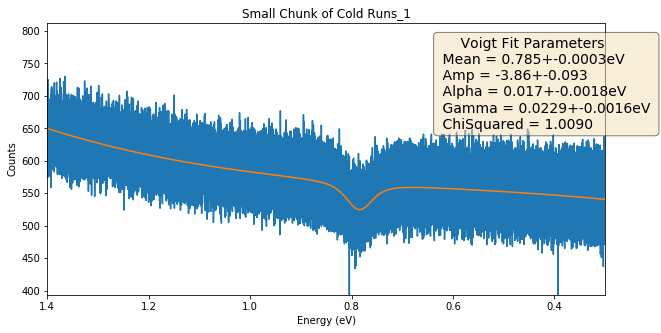

In [13]:
#define the range of values to fit
fitWindowLeft = 0.3
fitWindowRight = 1.4

binSize = 1
makePlot = True

#rebin the data
rebinnedWithout = rebinning(eVHist, binSize)


rightCross, leftCross = getTimeWindowInIndices(fitWindowLeft, fitWindowRight, rebinnedWithout[1])
'''na.plt.plot(eVHist[1][:-1], rebinnedWithout[0])
na.plt.plot(eVHist[1][leftCross:rightCross], rebinnedWithout[0][leftCross:rightCross])
na.plt.xscale('log')
na.plt.show()'''


fitParams, errors, chiSquareds = fitDataSet(rebinnedWithout, leftCross, rightCross, dataSetName+'_'+str(binSize),-1, makePlot)

#fit over a range of bin values to determine the best bin size
binSizes = na.np.arange(1,100)
#chiSquaredVals, fitParams, errors = fitMultipleBinSizes(timeHist, fitWindowLeft, fitWindowRight, binSizes, makePlot = False)

In [14]:
for i in range(len(fitParams)):
    print(fitParams[i], errors[i])

506.81130412069734 1.0131372114347554
159.66458257613948 4.497308593947853
-187.5719993414223 5.972299987208611
104.65541654022596 2.470827517795399
-3.8595564680365357 0.09274622092747471
0.7848458010984082 0.0003081434315326227
0.016825150090820563 0.0018082176476042246
0.022890045893615638 0.0016336712698064306


NameError: name 'chiSquaredVals' is not defined

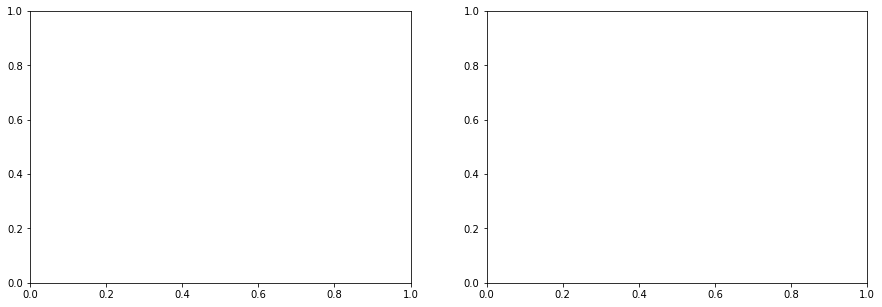

In [15]:
fitParamNames = ['const', 'linear', 'quad', 'cubic', 'amp', 'mean', r'$\alpha$', r'$\gamma$']
#examine the chi squared and the relative error in coefficients
rcParams['figure.figsize'] = 15, 5 #change how large the plot will be
f, (ax1, ax2) = na.plt.subplots(1, 2) #create the 2 plots side by side
#plot the chi squared part
ax1.plot(binSizes, chiSquaredVals)
ax1.set_title(r'$\chi^2$ vs Bin Width')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel('Bin Width (10ns units)')
ax1.set_ylabel(r'$\chi^2$')
#plot the errors
for val in range(len(fitParamNames)):
    #grab the right column
    col = []
    for j in range(len(errors)):
        col.append(abs(errors[j][val]/fitParams[j][val]))
    ax2.plot(binSizes, col, label=fitParamNames[val])
ax2.set_title('Errors vs Bin Size')
ax2.set_xlabel('Bin Width (10ns units)')
ax2.set_ylabel('Relative Error')
ax2.legend(loc='upper left')
ax2.set_xscale('log')
ax2.set_yscale('log')
f.suptitle('Analysis of Error vs Bin Width')
f.savefig('analysisOfBinWidthAndRelativeErrorNewData.png')
